In [1]:
#imports
import os, re, joblib
from datetime import datetime
import pandas as pd
import numpy as np
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.metrics.pairwise import linear_kernel
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#create folders
os.makedirs('models', exist_ok=True)
os.makedirs('outputs', exist_ok=True)

In [3]:
#load dataset and quick inspect
df = pd.read_csv("dataset.csv", low_memory=False)
df.shape

(55677, 19)

In [4]:
#show columns
print(df.columns.tolist())

['video_id', 'title', 'title_len_chars', 'title_len_tokens', 'publishedAt', 'channelId', 'channelTitle', 'categoryId', 'trending_date', 'views_per_day', 'tags', 'num_tags', 'view_count', 'likes', 'dislikes', 'comment_count', 'comments_disabled', 'engagement_label', 'description']


In [5]:
#show head
df.head(3)

,video_id,title,title_len_chars,title_len_tokens,publishedAt,channelId,channelTitle,categoryId,trending_date,views_per_day,tags,num_tags,view_count,likes,dislikes,comment_count,comments_disabled,engagement_label,description
0,KX06ksuS6Xo,diljit dosanjh clash official music video g o a t,49,10,2020-08-11 13:15:00,UCZRdNleCgW-BGUJf-bbjzQg,diljit dosanjh,10,2020-08-12 05:45:00,9140911.0,clash diljit dosanjh diljit dosanjh diljit dos...,62,9140911,296541,6180,30059,False,1,clash official music video performed by diljit...
1,3LqQB4HV8qg,i rescued my cat from the sewer,31,7,2020-08-10 03:00:00,UCGCPAOQDZa_TTTXDr5byjww,joey graceffa,15,2020-08-12 05:45:00,131725.0,joey graceffa joey graceffa pregnant cat rescu...,23,263450,22669,291,4591,False,0,i rescued my cat after she got stuck in the se...
2,UcXVnupm0zk,did you feel it magnitude earthquake in north ...,54,9,2020-08-09 18:54:00,UC-RxXi2Xws6Uk22vp-sLbGA,wcnc,25,2020-08-12 05:45:00,135682.0,weather earthquake shaking charlotte north car...,8,271364,2114,187,1637,False,0,according to chief meteorologist brad panovich...


In [6]:
#show info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55677 entries, 0 to 55676
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   video_id           55677 non-null  object 
 1   title              55677 non-null  object 
 2   title_len_chars    55677 non-null  int64  
 3   title_len_tokens   55677 non-null  int64  
 4   publishedAt        55677 non-null  object 
 5   channelId          55677 non-null  object 
 6   channelTitle       55677 non-null  object 
 7   categoryId         55677 non-null  int64  
 8   trending_date      55677 non-null  object 
 9   views_per_day      55677 non-null  float64
 10  tags               55677 non-null  object 
 11  num_tags           55677 non-null  int64  
 12  view_count         55677 non-null  int64  
 13  likes              55677 non-null  int64  
 14  dislikes           55677 non-null  int64  
 15  comment_count      55677 non-null  int64  
 16  comments_disabled  556

In [7]:
#show describe
df.describe()

,title_len_chars,title_len_tokens,categoryId,views_per_day,num_tags,view_count,likes,dislikes,comment_count,engagement_label
count,55677.000000,55677.00000,55677.000000,5.567700e+04,55677.000000,5.567700e+04,5.567700e+04,55677.000000,5.567700e+04,55677.000000
mean,51.955224,8.86727,18.946908,8.256992e+05,37.487257,9.187459e+05,5.016802e+04,448.251361,4.098698e+03,0.250013
std,19.310639,3.29653,6.192947,1.716463e+06,22.846157,2.165089e+06,1.659544e+05,3535.148750,3.035387e+04,0.433024
min,3.000000,1.00000,1.000000,0.000000e+00,1.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000
25%,37.000000,6.00000,17.000000,2.045850e+05,16.000000,2.231550e+05,6.920000e+03,0.000000,5.900000e+02,0.000000
50%,49.000000,8.00000,20.000000,3.997740e+05,37.000000,4.308110e+05,1.734900e+04,0.000000,1.372000e+03,0.000000
75%,65.000000,11.00000,24.000000,8.541320e+05,58.000000,9.106360e+05,4.266400e+04,200.000000,3.106000e+03,1.000000
max,100.000000,24.00000,29.000000,6.988069e+07,104.000000,1.021700e+08,7.114845e+06,405397.000000,3.400267e+06,1.000000


In [8]:
#canonicalize text cols and parse dates
df = df.rename(columns=lambda c: c.strip())
df['title'] = df['title'].astype(str).str.strip()
df['tags'] = df['tags'].astype(str).fillna('')
df['description'] = df['description'].astype(str).fillna('')
df['publishedAt'] = pd.to_datetime(df['publishedAt'], errors='coerce')
df['trending_date'] = pd.to_datetime(df['trending_date'], errors='coerce')
df['view_count'] = pd.to_numeric(df['view_count'], errors='coerce').fillna(0).astype(float)
df[['publishedAt','trending_date']].isna().sum()

publishedAt      0
trending_date    0
dtype: int64

In [9]:
#drop rows missing essentials and show counts before/after
before = len(df)
df = df.dropna(subset=['title','view_count','publishedAt','trending_date']).copy()
after = len(df)
print('rows before:', before, 'after:', after)

rows before: 55677 after: 55677


In [10]:
# Create age_days for analysis (views_per_day is already loaded from CSV)
df['age_days'] = (df['trending_date'] - df['publishedAt']).dt.total_seconds().div(3600*24)
df['age_days'] = df['age_days'].clip(lower=1)

# Check stats
df[['age_days', 'views_per_day']].describe().T

,count,mean,std,min,25%,50%,75%,max
age_days,55677.0,1.333371,1.254003e+00,1.0,1.0,1.0,1.25,3.033333e+01
views_per_day,55677.0,825699.177655,1.716463e+06,0.0,204585.0,399774.0,854132.00,6.988069e+07


In [11]:
#create bucket and label using transform
df['bucket_month'] = df['trending_date'].dt.to_period('M').astype(str)
df['bucket_q90'] = df.groupby('bucket_month')['views_per_day'].transform(lambda x: x.quantile(0.90, interpolation='linear'))
df['label'] = (df['views_per_day'] >= df['bucket_q90']).astype(int)
df.drop(columns=['bucket_q90'], inplace=True)
print('positive fraction:', df['label'].mean())

positive fraction: 0.10034664224006322


In [12]:
# Dataset Range: 28 July 2020 to 15 April 2024 (approx 45 months)

# 80%: Approx June 2023
train_cutoff = pd.Timestamp('2023-06-10')

# 90%: Approx November 2023
val_cutoff = pd.Timestamp('2023-11-3')

# Apply the split
train_df = df[df['trending_date'] <= train_cutoff].copy()
val_df = df[(df['trending_date'] > train_cutoff) & (df['trending_date'] <= val_cutoff)].copy()
test_df = df[df['trending_date'] > val_cutoff].copy()

# Verification
print(f"Train size: {len(train_df)} ({len(train_df)/len(df):.1%})")
print(f"Val size:   {len(val_df)} ({len(val_df)/len(df):.1%})")
print(f"Test size:  {len(test_df)} ({len(test_df)/len(df):.1%})")

Train size: 44529 (80.0%)
Val size:   5555 (10.0%)
Test size:  5593 (10.0%)


In [13]:
#TF-IDF fit on training titles
tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=5, max_features=20000)
tfidf.fit(train_df['title'])
joblib.dump(tfidf, "models/tfidf.pkl")
X_train_tfidf = tfidf.transform(train_df['title'])
X_val_tfidf = tfidf.transform(val_df['title'])

In [14]:
#evaluation helpers (Precision@k, NDCG@k)
def precision_at_k_binary(labels, scores, k=5):
    order = np.argsort(scores)[::-1][:k]
    return labels.iloc[order].sum() / k
def dcg_at_k_binary(labels, scores, k=5):
    order = np.argsort(scores)[::-1][:k]
    rel = labels.iloc[order].values
    gains = 2**rel - 1
    discounts = np.log2(np.arange(2, k+2))
    return (gains / discounts).sum()
def ndcg_at_k_binary(labels, scores, k=5):
    ideal = labels.sort_values(ascending=False).reset_index(drop=True)
    idcg = dcg_at_k_binary(ideal, np.arange(len(ideal)), k)
    if idcg == 0:
        return 0.0
    return dcg_at_k_binary(labels, scores, k) / idcg

In [15]:
#TF-IDF + cosine baseline evaluation (sampled)
train_matrix = X_train_tfidf
n_samples = min(500, val_df.shape[0])
sample_idx = val_df.sample(n=n_samples, random_state=42).index
prec_list = []
ndcg_list = []
for qi in sample_idx:
    q_vec = tfidf.transform([val_df.loc[qi,'title']])
    sims = linear_kernel(q_vec, train_matrix).flatten()
    top_idx = sims.argsort()[::-1][:5]
    labels_top = train_df.iloc[top_idx]['label'].reset_index(drop=True)
    prec_list.append(labels_top.sum() / 5)
    ndcg_list.append(ndcg_at_k_binary(labels_top, sims[top_idx], k=5))
print('TF-IDF Precision@5:', np.mean(prec_list))
print('TF-IDF NDCG@5:', np.mean(ndcg_list))

TF-IDF Precision@5: 0.1172
TF-IDF NDCG@5: 0.4865882172267695


In [16]:
# numeric features
def numeric_feats(df_local):
    out = pd.DataFrame(index=df_local.index)
    
    # These are the only two features that actually work after your cleaning
    out['title_len'] = df_local['title'].str.len()
    out['word_count'] = df_local['title'].str.split().str.len().fillna(0)
    return out

X_train_num = numeric_feats(train_df)
X_val_num   = numeric_feats(val_df)
X_test_num  = numeric_feats(test_df)

In [17]:
#Logistic Regression pipeline (scale numeric + combine)
scaler = StandardScaler()
X_train_num_s = scaler.fit_transform(X_train_num)
X_val_num_s   = scaler.transform(X_val_num)
X_test_num_s  = scaler.transform(X_test_num)
X_train = hstack([tfidf.transform(train_df['title']), X_train_num_s])
X_val   = hstack([tfidf.transform(val_df['title']),   X_val_num_s])
X_test  = hstack([tfidf.transform(test_df['title']),  X_test_num_s])
y_train = train_df['label'].values
y_val   = val_df['label'].values
y_test  = test_df['label'].values
lr = LogisticRegression(max_iter=1000, C=1.0, class_weight='balanced', random_state=42)
lr.fit(X_train, y_train)
y_val_proba  = lr.predict_proba(X_val)[:,1]
y_test_proba = lr.predict_proba(X_test)[:,1]
print('LR val AUC:', roc_auc_score(y_val, y_val_proba))
print('LR test AUC:', roc_auc_score(y_test, y_test_proba))
os.makedirs('models', exist_ok=True)
joblib.dump(lr, 'models/logistic_regression.pkl')
joblib.dump(scaler, 'models/scaler.pkl')
joblib.dump(tfidf, 'models/tfidf.pkl')

LR val AUC: 0.8012972095028438
LR test AUC: 0.7935368331999963


['models/tfidf.pkl']

In [18]:
#Random Forest pipeline (reduced TF-IDF + SVD -> dense)
tfidf_rf = TfidfVectorizer(ngram_range=(1,2), min_df=5, max_features=5000)
tfidf_rf.fit(train_df['title'])
joblib.dump(tfidf_rf, "models/tfidf_rf.pkl")
X_train_tfidf_rf = tfidf_rf.transform(train_df['title'])
X_val_tfidf_rf   = tfidf_rf.transform(val_df['title'])
X_test_tfidf_rf  = tfidf_rf.transform(test_df['title'])
svd = TruncatedSVD(n_components=200, random_state=42)
X_train_svd = svd.fit_transform(X_train_tfidf_rf)
X_val_svd   = svd.transform(X_val_tfidf_rf)
X_test_svd  = svd.transform(X_test_tfidf_rf)
X_train_rf = np.hstack([X_train_svd, X_train_num.fillna(0).to_numpy()])
X_val_rf   = np.hstack([X_val_svd,   X_val_num.fillna(0).to_numpy()])
X_test_rf  = np.hstack([X_test_svd,  X_test_num.fillna(0).to_numpy()])
rf = RandomForestClassifier(n_estimators=200, max_depth=30, class_weight='balanced', n_jobs=-1, random_state=42, oob_score=True)
rf.fit(X_train_rf, y_train)
y_val_rf  = rf.predict_proba(X_val_rf)[:,1]
y_test_rf = rf.predict_proba(X_test_rf)[:,1]
from sklearn.metrics import roc_auc_score
print('RF val AUC:', roc_auc_score(y_val, y_val_rf))
print('RF test AUC:', roc_auc_score(y_test, y_test_rf))
os.makedirs('models', exist_ok=True)
joblib.dump(rf, 'models/random_forest.pkl')
joblib.dump(tfidf_rf, 'models/tfidf_rf.pkl')
joblib.dump(svd, 'models/svd.pkl')

RF val AUC: 0.7756759969693107
RF test AUC: 0.7303108626869282


['models/svd.pkl']

In [19]:
# KNN Classifier (Must use SCALED numeric features for Euclidean distance to work)

# 1. Prepare Data: Combine SVD (Text) with Scaled Numeric Features
X_train_knn = np.hstack([X_train_svd, X_train_num_s])
X_val_knn   = np.hstack([X_val_svd,   X_val_num_s])
X_test_knn  = np.hstack([X_test_svd,  X_test_num_s])

# 2. Train KNN
knn_clf = KNeighborsClassifier(n_neighbors=20, n_jobs=-1)
knn_clf.fit(X_train_knn, y_train)
knn_proba = knn_clf.predict_proba(X_test_knn)[:,1]

# 3. Evaluate
print('KNN val AUC:', roc_auc_score(y_val, knn_clf.predict_proba(X_val_knn)[:,1]))
print('KNN test AUC:', roc_auc_score(y_test, knn_clf.predict_proba(X_test_knn)[:,1]))

# 4. Save
joblib.dump(knn_clf, 'models/knn_classifier.pkl')

KNN val AUC: 0.7195609797319071
KNN test AUC: 0.6806590951050108


['models/knn_classifier.pkl']

In [20]:
# 1. Logistic Regression (Already calculated in In[17])
print(f"Logistic Regression AUC: {roc_auc_score(y_test, y_test_proba):.4f}")

# 2. Random Forest (Already calculated in In[18])
print(f"Random Forest AUC: {roc_auc_score(y_test, y_test_rf):.4f}")

# 3. KNN 
print(f"KNN AUC: {roc_auc_score(y_test, knn_proba):.4f}")

Logistic Regression AUC: 0.7935
Random Forest AUC: 0.7303
KNN AUC: 0.6807


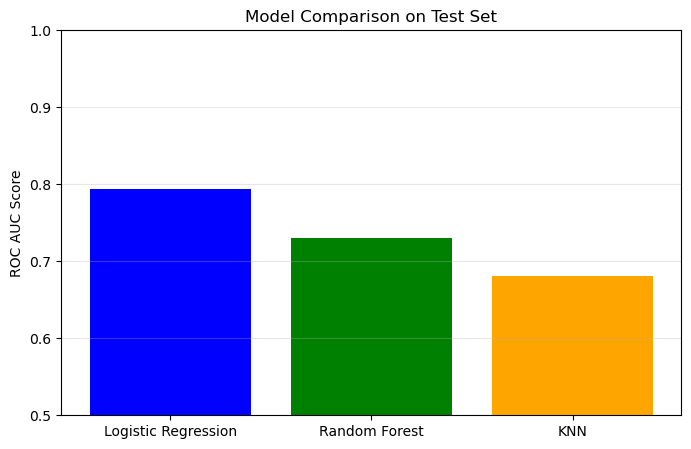

In [21]:
#Comparison Bar Chart
model_names = ['Logistic Regression', 'Random Forest', 'KNN']
auc_scores = [
    roc_auc_score(y_test, y_test_proba),
    roc_auc_score(y_test, y_test_rf),
    roc_auc_score(y_test, knn_proba)
]

plt.figure(figsize=(8, 5))
plt.bar(model_names, auc_scores, color=['blue', 'green', 'orange'])
plt.ylim(0.5, 1.0)
plt.ylabel('ROC AUC Score')
plt.title('Model Comparison on Test Set')
plt.grid(axis='y', alpha=0.3)
plt.savefig('outputs/model_comparison.png')
plt.show()

In [22]:
# TF-IDF ranking sample on test (sample 200 queries)

train_matrix = X_train_tfidf 

# Sample 200 random titles from the Test set to act as "User Queries"
test_sample_idx = test_df.sample(n=min(200, test_df.shape[0]), random_state=42).index

prec_list_test = []
ndcg_list_test = []

print("Running TF-IDF Baseline Evaluation on Test Set:")

for qi in test_sample_idx:
    # 1. Vectorize the query (Test Title)
    q_vec = tfidf.transform([test_df.loc[qi, 'title']])
    
    # 2. Calculate Cosine Similarity against the Database (Training Set)
    sims = linear_kernel(q_vec, train_matrix).flatten()
    
    # 3. Retrieve Top 5 Matches
    top_idx = sims.argsort()[::-1][:5]
    
    # 4. Get the labels (High/Low) of these Top 5 matches from Training Data
    labels_top = train_df.iloc[top_idx]['label'].reset_index(drop=True)
    
    # 5. Calculate Metrics
    prec_list_test.append(labels_top.sum() / 5)
    ndcg_list_test.append(ndcg_at_k_binary(labels_top, sims[top_idx], k=5))

print(f'TF-IDF (test) Precision@5: {np.mean(prec_list_test):.4f}')
print(f'TF-IDF (test) NDCG@5:      {np.mean(ndcg_list_test):.4f}')

Running TF-IDF Baseline Evaluation on Test Set:
TF-IDF (test) Precision@5: 0.1030
TF-IDF (test) NDCG@5:      0.4943


In [23]:
# --- Save Data for Report ---

# 1. Create a copy of the test data for reporting
report_df = test_df[['video_id', 'title', 'view_count', 'views_per_day', 'label']].copy()

# 2. Add the Random Forest Prediction Score (The "AI's Opinion")
report_df['AI_Score'] = y_test_rf 

# 3. Save to CSV
os.makedirs('outputs', exist_ok=True)
report_df.to_csv('outputs/dataset_for_report.csv', index=False)

# 4. Save Split Counts
split_counts = pd.DataFrame({
    'Subset': ['Training', 'Validation', 'Test'],
    'Count': [len(train_df), len(val_df), len(test_df)],
    'Percentage': [
        len(train_df)/len(df), 
        len(val_df)/len(df), 
        len(test_df)/len(df)
    ]
})
split_counts.to_csv('outputs/split_counts.csv', index=False)

print("Report files generated successfully in 'outputs/' folder.")
print(split_counts)

Report files generated successfully in 'outputs/' folder.
       Subset  Count  Percentage
0    Training  44529    0.799774
1  Validation   5555    0.099772
2        Test   5593    0.100454


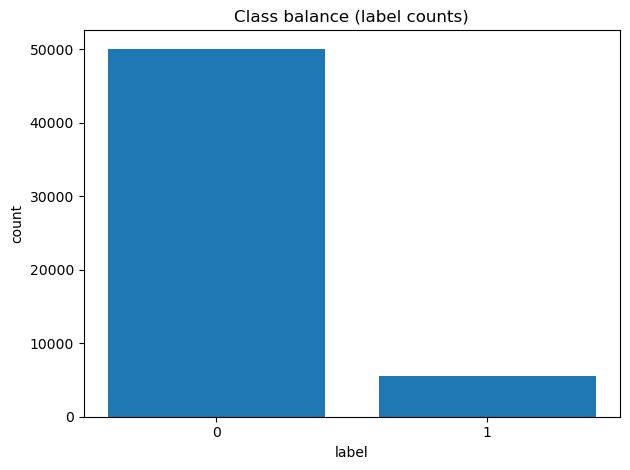

In [24]:
# class_balance_plot.py
os.makedirs('outputs', exist_ok=True)
counts = df['label'].value_counts().sort_index()
plt.figure()
plt.bar(counts.index.astype(str), counts.values)
plt.xlabel('label')
plt.ylabel('count')
plt.title('Class balance (label counts)')
plt.tight_layout()
plt.savefig('outputs/class_balance.png')
plt.show()

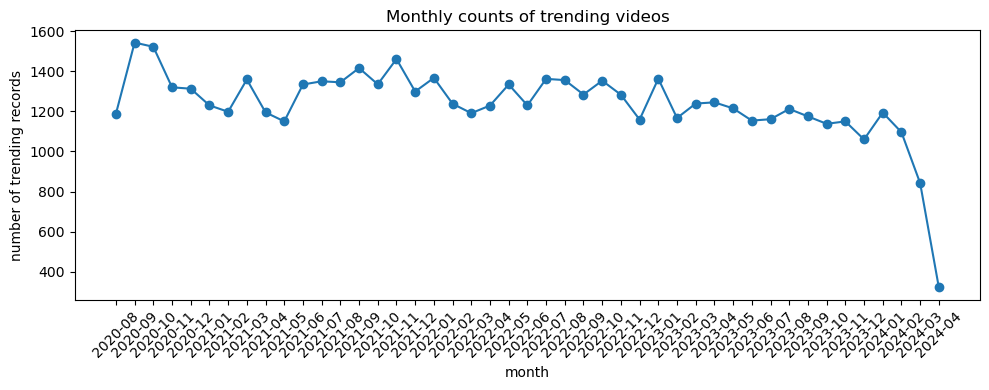

In [25]:
# monthly_counts_timeseries.py
mcounts = df.groupby(df['trending_date'].dt.to_period('M')).size()
months = [str(x) for x in mcounts.index]
plt.figure(figsize=(10,4))
plt.plot(months, mcounts.values, marker='o')
plt.xticks(rotation=45)
plt.xlabel('month')
plt.ylabel('number of trending records')
plt.title('Monthly counts of trending videos')
plt.tight_layout()
plt.savefig('outputs/monthly_counts.png')
plt.show()


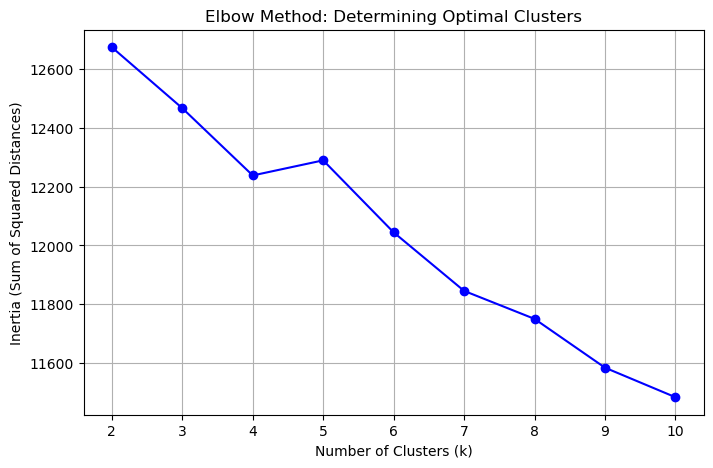

In [26]:
# Figure: K-Means Elbow Plot (The "Unsupervised" Proof)
# Use the SVD data (Text features) to find clusters
# This is fast because we are using the reduced 200 dimensions, not 20,000
X_topic_data = X_train_svd 

inertia = []
k_range = range(2, 11) # Test from 2 to 10 clusters

# Calculate inertia for each k
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_topic_data)
    inertia.append(kmeans.inertia_)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.title('Elbow Method: Determining Optimal Clusters')
plt.grid(True)
plt.xticks(k_range)
plt.savefig('outputs/fig_kmeans_elbow.png')
plt.show()

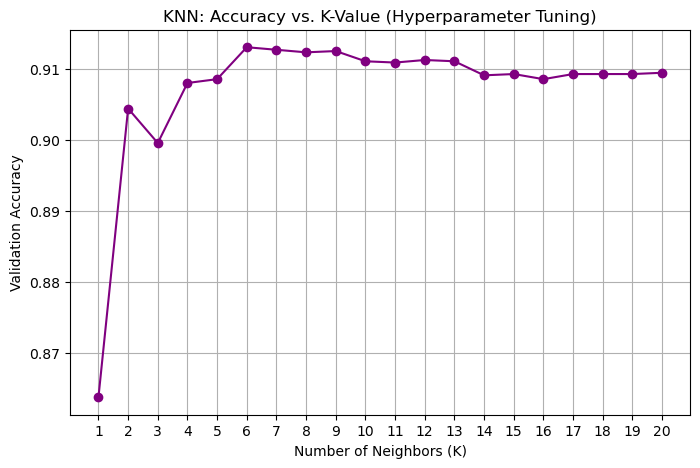

In [27]:
# Figure: KNN Hyperparameter Tuning (Accuracy vs K)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

k_values = range(1, 21) # Test K from 1 to 20
accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_knn, y_train) # Use your training data
    score = knn.score(X_val_knn, y_val) # Use your validation data
    accuracies.append(score)

plt.figure(figsize=(8, 5))
plt.plot(k_values, accuracies, marker='o', linestyle='-', color='purple')
plt.title('KNN: Accuracy vs. K-Value (Hyperparameter Tuning)')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Validation Accuracy')
plt.xticks(k_values)
plt.grid(True)
plt.savefig('outputs/fig_knn_tuning.png')
plt.show()

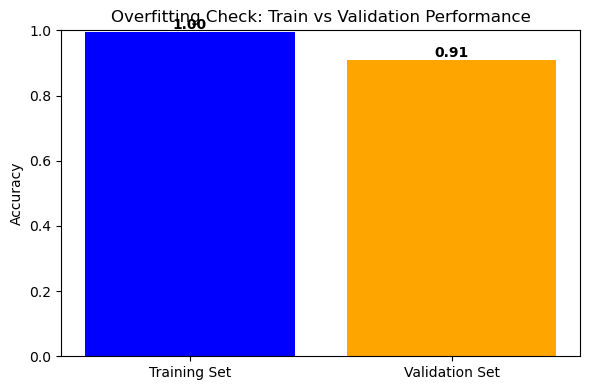

In [28]:
# Figure 12: Overfitting Check (Train vs Validation Accuracy)
from sklearn.metrics import accuracy_score

# Get predictions
y_train_pred = rf.predict(X_train_rf)
y_val_pred = rf.predict(X_val_rf)

# Calculate accuracies
train_acc = accuracy_score(y_train, y_train_pred)
val_acc = accuracy_score(y_val, y_val_pred)

plt.figure(figsize=(6, 4))
plt.bar(['Training Set', 'Validation Set'], [train_acc, val_acc], color=['blue', 'orange'])
plt.ylabel('Accuracy')
plt.title('Overfitting Check: Train vs Validation Performance')
plt.ylim(0, 1.0)

# Add text labels
plt.text(0, train_acc + 0.01, f'{train_acc:.2f}', ha='center', fontweight='bold')
plt.text(1, val_acc + 0.01, f'{val_acc:.2f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('outputs/fig_overfitting_check.png')
plt.show()

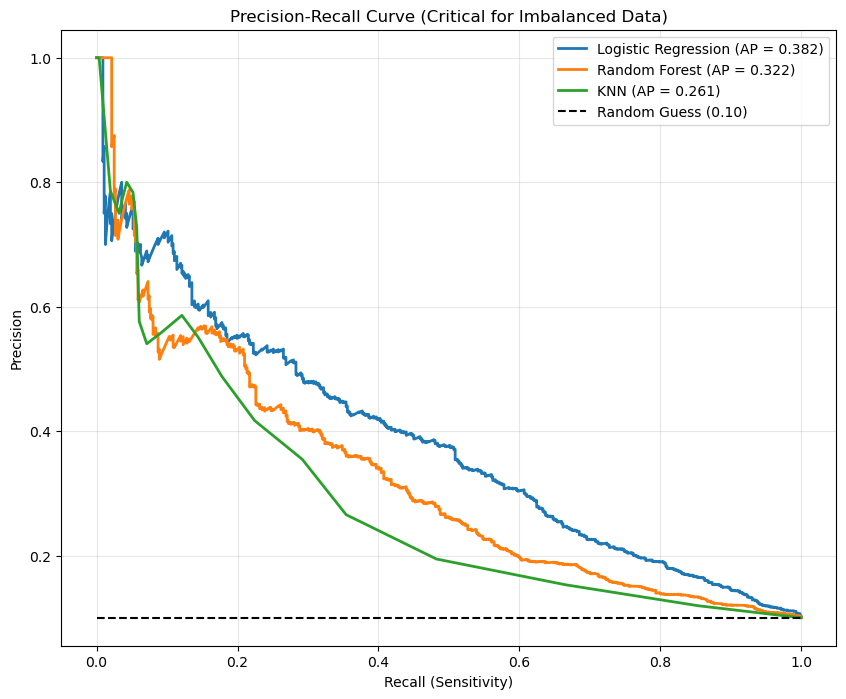

In [29]:
# Figure 8: Precision-Recall Curve Comparison

plt.figure(figsize=(10, 8))

# 1. Logistic Regression
precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_test_proba)
ap_lr = average_precision_score(y_test, y_test_proba)
plt.plot(recall_lr, precision_lr, label=f'Logistic Regression (AP = {ap_lr:.3f})', linewidth=2)

# 2. Random Forest
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_test_rf)
ap_rf = average_precision_score(y_test, y_test_rf)
plt.plot(recall_rf, precision_rf, label=f'Random Forest (AP = {ap_rf:.3f})', linewidth=2)

# 3. KNN
# (Ensure knn_proba is calculated, if not re-run predict_proba)
# knn_proba = knn_clf.predict_proba(X_test_knn)[:,1] 
precision_knn, recall_knn, _ = precision_recall_curve(y_test, knn_proba)
ap_knn = average_precision_score(y_test, knn_proba)
plt.plot(recall_knn, precision_knn, label=f'KNN (AP = {ap_knn:.3f})', linewidth=2)

# Plot Baseline (Random Guess = Fraction of Positives)
baseline = y_test.mean()
plt.plot([0, 1], [baseline, baseline], 'k--', label=f'Random Guess ({baseline:.2f})')

plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Critical for Imbalanced Data)')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig('outputs/fig_pr_curve_comparison.png')
plt.show()

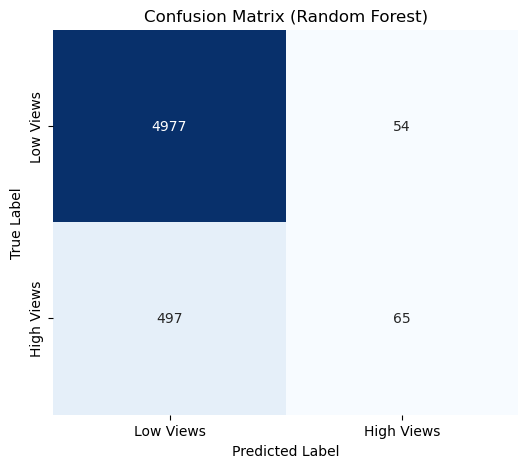

In [30]:
# Get binary predictions (0 or 1) instead of probabilities
y_pred_rf = rf.predict(X_test_rf)

# Generate Matrix
cm = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Low Views', 'High Views'],
            yticklabels=['Low Views', 'High Views'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Random Forest)')
plt.savefig('outputs/fig_confusion_matrix_rf.png')
plt.show()

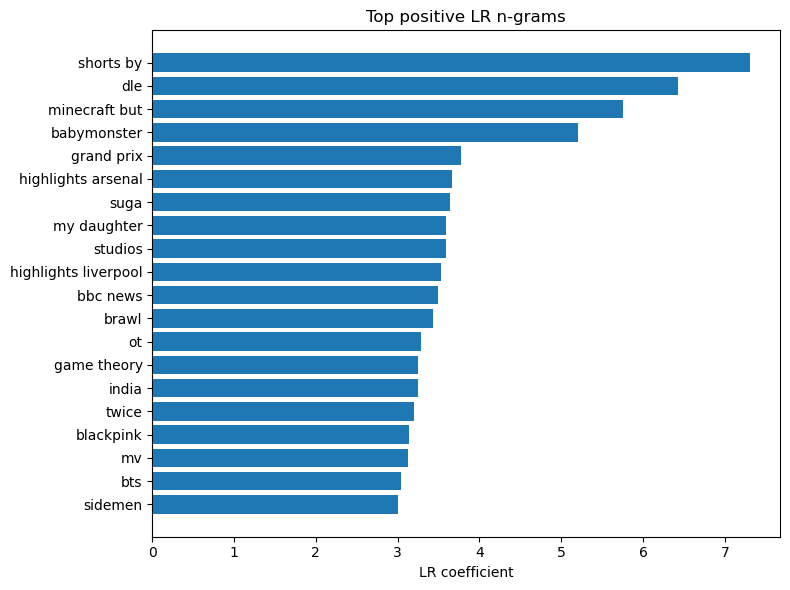

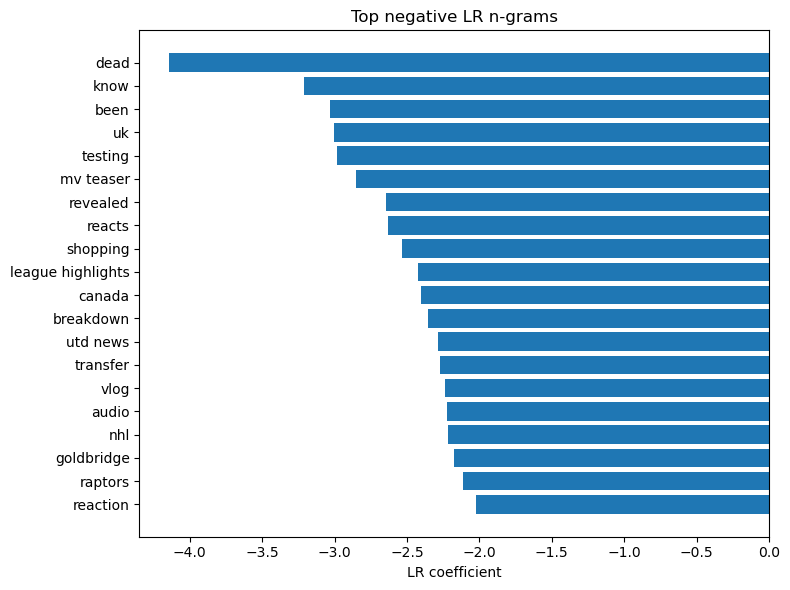

In [31]:
# fig_lr_topcoeffs.py
import numpy as np, matplotlib.pyplot as plt
n=20
vec = tfidf  # fitted vectorizer used in LR
feature_names = np.array(vec.get_feature_names_out())
coefs = lr.coef_.ravel()
top_pos_idx = np.argsort(coefs)[-n:][::-1]
top_neg_idx = np.argsort(coefs)[:n]

plt.figure(figsize=(8,6))
plt.barh(np.arange(n)[::-1], coefs[top_pos_idx])
plt.yticks(np.arange(n), feature_names[top_pos_idx])
plt.xlabel('LR coefficient')
plt.title('Top positive LR n-grams')
plt.tight_layout()
plt.savefig('outputs/fig_lr_top_pos_ngrams.png')
plt.show()

plt.figure(figsize=(8,6))
plt.barh(np.arange(n)[::-1], coefs[top_neg_idx])
plt.yticks(np.arange(n), feature_names[top_neg_idx])
plt.xlabel('LR coefficient')
plt.title('Top negative LR n-grams')
plt.tight_layout()
plt.savefig('outputs/fig_lr_top_neg_ngrams.png')
plt.show()


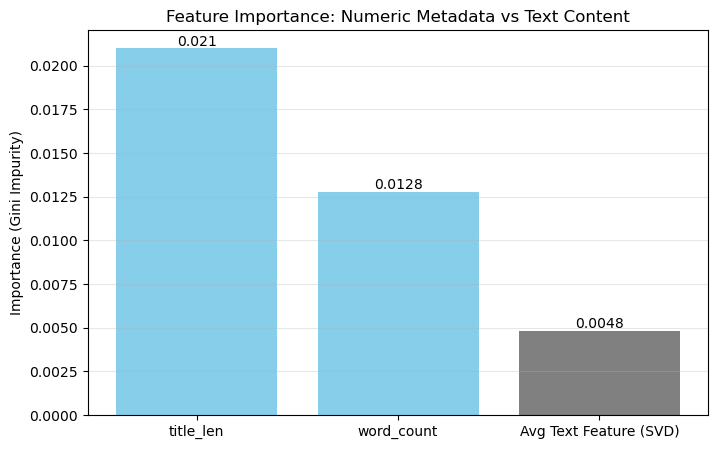

In [32]:
# Figure 6: Random Forest Numeric Feature Importance
# 1. Get all feature names
svd_feature_names = [f'SVD_{i}' for i in range(200)]
# Numeric features (Ensure these match the columns in X_train_num)
numeric_feature_names = ['title_len', 'word_count'] 

all_feature_names = svd_feature_names + numeric_feature_names

# 2. Get Importances from the trained RF model
importances = rf.feature_importances_

# 3. Separate them for visualization
# We want to see how the Numeric Features compare to the average Text feature
numeric_indices = [200, 201] # The last two features in your stack
numeric_importances = importances[numeric_indices]

# Calculate average importance of text features for comparison
avg_text_importance = np.mean(importances[:200])

# Prepare data for plotting
plot_names = numeric_feature_names + ['Avg Text Feature (SVD)']
plot_values = list(numeric_importances) + [avg_text_importance]

plt.figure(figsize=(8, 5))
bars = plt.bar(plot_names, plot_values, color=['skyblue', 'skyblue', 'gray'])
plt.ylabel('Importance (Gini Impurity)')
plt.title('Feature Importance: Numeric Metadata vs Text Content')
plt.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), ha='center', va='bottom')

plt.savefig('outputs/fig_rf_feature_importance.png')
plt.show()